## Notebook for machine learning methods for rf-based detection & classification
-  exploring, SVM, Logistic regression with PSD

In [1]:
import os
import numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

from helper_functions import *
from latency_helpers import *
from loading_functions import *
from file_paths import *
from models import *

In [2]:
import importlib
import models
importlib.reload(models)
from models import *

# DroneDetect

### Load Features

In [11]:
feat_folder = dronedetect_feat_path
feat_name = 'PSD'
t_seg = 20 #ms
n_per_seg = 1024
interferences = ['WIFI', 'BLUE', 'BOTH', 'CLEAN']
output_name = 'drones'
feat_format = 'ARR'

dataset = DroneDetectTorch(feat_folder, feat_name, t_seg, n_per_seg, feat_format,
                                output_name, interferences)
X_use, y_use = dataset.get_arrays()

# test partial data
# i_test= list(range(0,38900,100))
# X_use, y_use = dataset.__getitem__(i_test)


Directory Name:  /home/kzhou/main/Features/ARR_PSD_1024_20/
dataset size 38978
shape of each item (1024,)


### Run Model

In [12]:
model = PsdSVM(t_seg, n_per_seg)

In [13]:
accs, f1s, runts = model.run_cv(X_use, y_use, k_fold=3)

1it [03:45, 225.21s/it]

Fold 1: Accuracy: 0.85,	 F1: 0.847, 	 Runtime: 0.00864


2it [07:24, 221.93s/it]

Fold 2: Accuracy: 0.846,	 F1: 0.844, 	 Runtime: 0.0084


3it [11:05, 221.83s/it]

Fold 3: Accuracy: 0.848,	 F1: 0.846, 	 Runtime: 0.00842
PSD+SVM 3 Fold CV acc: 0.848, F1: 0.846, Run-time: 8.49ms


In [7]:
# search through parameters
Cs=list(map(lambda x:pow(2,x),range(-3,10,2)))
gammas=list(map(lambda x:pow(2,x),range(-3,10,2)))
parameters = {'C':Cs, 'gamma':gammas}

k_fold=3

accs, f1s, runts, best_params = model.run_gridsearch(X_use, y_use, parameters, k_fold)

Fold 1 Best Parameters: {'C': 2, 'gamma': 0.125}
Fold 1: Accuracy: 0.592,	 F1: 0.6, 	 Runtime: 0.000231
Fold 2 Best Parameters: {'C': 8, 'gamma': 0.125}
Fold 2: Accuracy: 0.554,	 F1: 0.589, 	 Runtime: 0.000233
Fold 3 Best Parameters: {'C': 2, 'gamma': 0.125}
Fold 3: Accuracy: 0.628,	 F1: 0.61, 	 Runtime: 0.000229
PSD+SVM 3 Fold GridSearch CV acc: 0.591, F1: 0.599, Run-time: 0.231ms


### Visualize Results

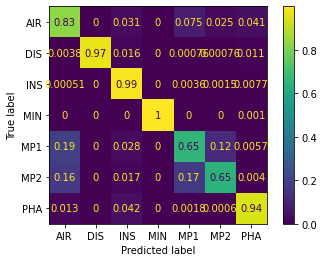

In [15]:
# Set-up train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_use, 
                                                    y_use, 
                                                    test_size=0.33, 
                                                    random_state=None)

# Train & Test
model.train(X_train, y_train)
preds = model.predict(X_test)
show_confusion_matrix(dataset, y_test, preds)

### Save Model

In [10]:
to_train_all = True # whether to retrain using all the data
model_name = 'SVM'+'_'+str(feat_name)+'_'+str(n_per_seg)+'_'+str(t_seg)+'_'+str(int(to_train_all))
model_path = '../temp_figs/'

if to_train_all:
    model.train(X_use, y_use)

model.save(model_path, model_name)

# pickle.dump(svc, open(model_path+model_name, 'wb'))

Model saved as: ../temp_figs/SVM_PSD_1024_20_1


## DroneRF Dataset

In [14]:
# Load features
feat_folder = dronerf_feat_path
feat_name = 'PSD'
feat_format = 'ARR'
highlow = 'H'
t_seg = 20
n_per_seg = 256
output_feat = 'drones'

dataset = DroneRFTorch(feat_folder, feat_name, t_seg,
                       feat_format, output_feat, highlow)


X_use, y_use = dataset.get_arrays()
# Xs_arr, y_arr = load_dronerf_features(feat_folder, feat_name, seg_len, n_per_seg, highlow, output_feat)


## Apply normalization
X_norm = Xs_arr
for n in range(len(Xs_arr)):
    X_norm[n] = Xs_arr[n]/max(Xs_arr[n])
X_norm.shape
y_arr = y_arr.reshape(len(y_arr),)

Xs_use = X_norm # Use normalized features
Xs_use.shape

print('X shape:', Xs_arr.shape, ' y shape:', y_arr.shape)

TypeError: __init__() missing 1 required positional argument: 'highlow'

-----------------

Prior to clean up

## Train Test split

In [80]:
# split data into K-fold
# k_fold = 5
# kf = KFold(n_splits=k_fold, random_state=1, shuffle=True)

# # model parameters
# Cs=list(map(lambda x:pow(2,x),range(-3,10,2)))
# gammas=list(map(lambda x:pow(2,x),range(-3,10,2)))

## SVM

In [81]:
### Not running for now- takes long time for gridsearchcv even with n_jobs -1
### Run all combination of data parameters with fixed parameters first

# best_params_ls = []
# acc_ls = []
# f1_ls = []
# runt_ls = []
# parameters = {'C':Cs, 'gamma':gammas}
# for train_ix, test_ix in kf.split(X_use):
    
#     # find the optimal hypber parameters
#     svc = svm.SVC(kernel='rbf')
#     clf = GridSearchCV(svc, parameters, n_jobs=1)
#     clf.fit(X_use[train_ix], y_use[train_ix])
    
#     print(clf.best_params_)
#     best_params_ls.append(clf.best_params_)
    
#     # predict on the test data
# #     y_pred = clf.predict(Xs_use[test_ix])
#     y_pred, runtimes = atomic_benchmark_estimator(clf, X_use[test_ix], '<U3', verbose=False) # predict & measure time
#     runt_ls.append(np.mean(runtimes))
    
#     acc = accuracy_score(y_use[test_ix], y_pred)
#     f1 = f1_score(y_use[test_ix], y_pred, average='weighted')
#     print('Accuracy: {:.3},\t F1: {:.3}'.format(acc,f1))
#     acc_ls.append(acc)
#     f1_ls.append(f1)

# # print(feat_name+': SVM K-fold average test acc:', np.mean(acc_ls), 'F1:', np.mean(f1_ls), 'Run-time:', np.mean(runt_ls)*1e3,'ms')
# out_msg = feat_name+': SVM K-fold average test acc: {:.3}, F1: {:.3}, Run-time: {:.3}ms'.format(np.mean(acc_ls), np.mean(f1_ls), np.mean(runt_ls)*1e3)
# print(out_msg)

In [82]:
# print out the size of the support vectors
# clf.best_estimator_.support_vectors_

In [83]:
Cs

[0.125, 0.5, 2, 8, 32, 128, 512]

## SVM with fixed hyperparameters

In [84]:
C_fix = 1 ##default params
gamma_fix = 'scale'

acc_ls = []
f1_ls = []
runt_ls = []

k_fold = 5
cv = KFold(n_splits=k_fold, random_state=None, shuffle=True)

for train_ix, test_ix in cv.split(X_use):
    svc = svm.SVC(kernel='rbf', C=C_fix, gamma = gamma_fix)
    svc.fit(X_use[train_ix], y_use[train_ix])
    # predict on the test data
    y_pred, runtimes = atomic_benchmark_estimator(svc, X_use[test_ix], output_type='<U3', verbose=False)
    runt_ls.append(np.mean(runtimes))
    
    acc = accuracy_score(y_use[test_ix], y_pred)
    f1 = f1_score(y_use[test_ix], y_pred, average='weighted')
    print('Accuracy: {:.3},\t F1: {:.3}'.format(acc,f1))
    acc_ls.append(acc)
    f1_ls.append(f1)

out_msg = feat_name+': SVM K-fold average test acc: {:.2}, F1: {:.2}, Run-time: {:.2}ms'.format(np.mean(acc_ls), np.mean(f1_ls), np.mean(runt_ls)*1e3)
print(out_msg)

Accuracy: 0.85,	 F1: 0.847
Accuracy: 0.848,	 F1: 0.845
Accuracy: 0.855,	 F1: 0.852
Accuracy: 0.851,	 F1: 0.849
Accuracy: 0.856,	 F1: 0.853
PSD: SVM K-fold average test acc: 0.85, F1: 0.85, Run-time: 9.9ms


In [127]:
gammas

[0.125, 0.5, 2, 8, 32, 128, 512]

In [85]:
print(svc.support_vectors_.shape)

(12375, 1024)


## Save Model

In [88]:
# feat_name = 'PSD'
# seg_len = 10
# n_per_seg = 512
import pickle
to_train_all = True # whether to retrain using all the data
model_name = 'SVM'+'_'+str(feat_name)+'_'+str(n_per_seg)+'_'+str(seg_len)+'_'+str(int(to_train_all))
model_path = '../saved_models/'
print('Model saved as:', model_name)

Model saved as: PSD_SVM_1024_20_1


In [89]:
if to_train_all:
    svc.fit(X_use, y_use)

pickle.dump(svc, open(model_path+model_name, 'wb'))


## Logistic Regression

In [ ]:
# best_params_ls = []
# score_ls = []

# parameters = {'C':[0.01,0.1,1,10,100,1000,10000]}

# for train_ix, test_ix in cv.split(Xs_arr):
    
#     # find the optimal hypber parameters
#     lr = LogisticRegression(max_iter=1000000)
#     clf = GridSearchCV(lr, parameters, n_jobs=1)
#     clf.fit(Xs_arr[train_ix], y_arr[train_ix])
    
#     print(clf.best_params_)
#     best_params_ls.append(clf.best_params_)
    
#     # predict on the test data
#     y_pred = clf.predict(Xs_arr[test_ix])
#     acc = accuracy_score(y_arr[test_ix], y_pred)
#     print(acc)
#     score_ls.append(acc)
    
# print(feat_file_name+': LR K-fold average test score:', np.mean(score_ls))

# Drone RF Dataset

In [150]:
# Load features
feat_folder = '../Features_DroneRF/'
feat_name = 'PSD'
highlow = 'H'
seg_len = 20
n_per_seg = 256
output_feat = 'drones'
Xs_arr, y_arr = load_dronerf_features(feat_folder, feat_name, seg_len, n_per_seg, highlow, output_feat)


## Apply normalization
X_norm = Xs_arr
for n in range(len(Xs_arr)):
    X_norm[n] = Xs_arr[n]/max(Xs_arr[n])
X_norm.shape
y_arr = y_arr.reshape(len(y_arr),)

Xs_use = X_norm # Use normalized features
Xs_use.shape

print('X shape:', Xs_arr.shape, ' y shape:', y_arr.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../Features_DroneRF/ARR_PSD_H_256_20/'

In [149]:
best_params_ls = []
acc_ls = []
f1_ls = []
runt_ls = []
parameters = {'C':Cs, 'gamma':gammas}
for train_ix, test_ix in cv.split(Xs_use):
    
    # find the optimal hypber parameters
    svc = svm.SVC(kernel='rbf')
    clf = GridSearchCV(svc, parameters, n_jobs=1)
    clf.fit(Xs_use[train_ix], y_arr[train_ix])
    
    print(clf.best_params_)
    best_params_ls.append(clf.best_params_)
    
    # predict on the test data
#     y_pred = clf.predict(Xs_use[test_ix])
    y_pred, runtimes = atomic_benchmark_estimator(clf, Xs_use[test_ix], 'int', verbose=False) # predict & measure time
    runt_ls.append(np.mean(runtimes))
    
    acc = accuracy_score(y_arr[test_ix], y_pred)
    f1 = f1_score(y_arr[test_ix], y_pred, average='weighted')
    print('Accuracy: {:.3},\t F1: {:.3}'.format(acc,f1))
    acc_ls.append(acc)
    f1_ls.append(f1)

# print(feat_name+': SVM K-fold average test acc:', np.mean(acc_ls), 'F1:', np.mean(f1_ls), 'Run-time:', np.mean(runt_ls)*1e3,'ms')
out_msg = feat_name+': SVM K-fold average test acc: {:.3}, F1: {:.3}, Run-time: {:.3}ms'.format(np.mean(acc_ls), np.mean(f1_ls), np.mean(runt_ls)*1e3)
print(out_msg)

KeyboardInterrupt: 

In [147]:
Cs

[0.125, 0.5, 2, 8, 32, 128, 512]

## Try Model on Gamut data

In [2]:
data_path = '/home/kzhou/Data/S3/leesburg_worker1/Features/'
Xgamut = load_gamut_features(data_path, 'psd')

100%|███████████████████████████████████████| 115/115 [00:00<00:00, 2255.41it/s]


In [7]:
# normalize data
## Apply normalization
X_gamut_norm = Xgamut
for n in range(len(Xgamut)):
    X_gamut_norm[n] = Xgamut[n]/max(Xgamut[n])

X_gamut_norm.max()

1.0

In [8]:
# Feed data through trained SVM model
y_gamut_pred = clf.predict(X_gamut_norm)


In [9]:
y_gamut_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,

## Save trained model for testing

In [ ]:
bestmodel = clf.best_estimator_

In [ ]:
filename = 'test_save_model.sav'
pickle.dump(bestmodel, open(filename, 'wb'))